In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml as dml
import dask_ml.model_selection as dcv
from dask.diagnostics import ProgressBar
import itertools
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random

import Modeling_Helper

import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# class PerformanceAnalysis:
#     def __init__(
#         self,
#         classifier, 
#         data, 
#         features, 
#         y_var, 
#         cv
#     ):
#         """
#         Initialises DataPrep
#         This class is used to prepare the data

#         :param portfolio_path: (str) path to portfolio data
#         :param profile_path: (str) path to profile data
#         :param transcript_path: (str) path to transcript

#         """

#         self.classifier = classifier
#         self.data = data
#         self.features = features
#         self.y_var = y_var
#         self.cv = cv
        
#     def plot_confusion_matrix(self, cm):
#         """
#         This function prints and plots the confusion matrix.
#         Normalization can be applied by setting `normalize=True`.
#         """
#         title='Confusion matrix'
#         plt.figure(figsize = (6,6))
#         plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
#         plt.title(title, fontsize = 15)
#         plt.colorbar()
#         tick_marks = np.arange(2)
#         plt.xticks([-0.5,1.5], [0,1], rotation=0)
#     #     plt.yticks(tick_marks, [0,1])

#         thresh = cm.max() / 2.
#         for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, cm[i, j],
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")

#         plt.tight_layout()
#         plt.ylabel('True label', fontsize = 15)
#         plt.xlabel('Predicted label', fontsize = 15)
        
#     def perf_analysis(self):
# #         print('**************', 'Performance:', which_data, '****************', '\n')


#         y_pred = self.classifier.predict(self.data[self.features])
#         y_pred = y_pred.round(0)
#         cnf_matrix = confusion_matrix(self.data[self.y_var], self.y_pred)
#         plot_confusion_matrix(cnf_matrix)


#         print("Accuracy:", round(accuracy_score(self.data[self.y_var], y_pred),2))
#         print("Precision:", round(precision_score(self.data[self.y_var], y_pred),2))
#         print("Recall:", round(recall_score(self.data[self.y_var], y_pred),2))
#         print("F1:", round(f1_score(self.data[self.y_var], y_pred),2))

#         if cv:

#             fpr, tpr, thresholds = roc_curve(self.data[self.y_var], classifier.predict_proba(self.data[self.features])[:, 1])

#         #     fpr, tpr, thresholds = roc_curve(data[y_var], model.predict(data[features]))
#         else:
#             fpr, tpr, thresholds = roc_curve(self.data[self.y_var], classifier.predict(self.data[self.features]))

#         roc_auc = auc(fpr,tpr)

#         # Plot ROC
#         plt.figure(figsize = (8,6))
#         plt.title(which_data+': ROC', fontsize = 15)
#         plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
#         plt.legend(loc='lower right', fontsize =15)
#         plt.plot([0,1],[0,1],'r--')
#         plt.xlim([-0.1,1.0])
#         plt.ylim([-0.1,1.01])
#         plt.ylabel('True Positive Rate', fontsize = 15)
#         plt.xlabel('False Positive Rate', fontsize = 15)
#         plt.show()


In [4]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,channel_social,channel_web,gender,age,income,membership_days,membership_month,membership_year,successful_offer,num_offers
0,user_100,discount_10_5,0.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0,1.0
1,user_100,bogo_7_10,336.0,bogo,7.0,10,10,3,1,1,1,0,F,68.0,84000.0,1941.0,7.0,2016.0,0,2.0
2,user_100,informational_4,408.0,informational,4.0,0,0,3,1,1,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0,3.0
3,user_100,discount_10_5,576.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1941.0,7.0,2016.0,0,4.0
4,user_1000,bogo_5_10,0.0,bogo,5.0,10,10,4,1,1,1,1,M,67.0,44000.0,1441.0,12.0,2017.0,0,1.0


In [5]:
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'] / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'] / 12)

In [6]:
# modeling_data.sample(50).plot.scatter('membership_month_sin','membership_month_cos').set_aspect('equal');


In [7]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
#     'difficulty',
    'gender', 
#     'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [8]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

In [9]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'num_offers',
 'membership_days_X_income',
 'num_channels_X_income',
 'age_X_income',
 'membership_month_sin',
 'membership_month_cos',
 'difficulty',
 'offer_id',
 'offer_type',
 'offer_reward',
 'gender',
 'membership_year']

In [10]:
# Y = modeling_data[y_var].astype(str)
# train_val_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)
# Y = train_val_df[y_var].astype(str)
# train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=2021, stratify = Y)


# train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
# val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
# test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)


# scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
# print(scale_pos_weight_val)
# (len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

In [11]:
ID_list = modeling_data['person'].unique().tolist()
random.seed(2021)
train_IDs = random.sample(ID_list, int(0.8*len(ID_list)))

train_val_df = modeling_data[modeling_data['person'].isin(train_IDs)]
test_df = modeling_data[~modeling_data['person'].isin(train_IDs)]
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(modeling_data[y_var]), np.mean(train_val_df[y_var]), np.mean(test_df[y_var]))

ID_list = train_val_df['person'].unique().tolist()
random.seed(2021)
train_IDs = random.sample(ID_list, int(0.8*len(ID_list)))

train_df = train_val_df[train_val_df['person'].isin(train_IDs)]
val_df = train_val_df[~train_val_df['person'].isin(train_IDs)]
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(val_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)


train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

0.7984077812198128 0.2015922187801872
0.029079644249025684 0.029100087613167007 0.02899867812293457
0.7984077812198128 0.2015922187801872
0.029119373776908025 0.029023197753042754 0.02899867812293457
33.34139784946237


In [12]:
# best = {'learning_rate': 0.0027995242034568827,
#  'num_leaves': 26,
#  'colsample_bytree': 0.9995686849369345,
#  'reg_alpha': 0.13449436788184574,
#  'reg_lambda': 0.9769689983386204,
#  'max_depth': 22,
#  'min_child_samples': 596,
#  'subsample': 0.5521506693185276}

# gbm_model = lgb.LGBMClassifier(objective = "binary", 
#                                metric = ['auc', 'binary_error'], 
#                                random_state=2021, 
#                                silent=True, 
#                                n_jobs=-1, 
#                                n_estimators=400, 
#                                scale_pos_weight = scale_pos_weight_val,
#                                learning_rate = best['learning_rate'],
#                                num_leaves = best['num_leaves'],
#                                colsample_bytree = best['colsample_bytree'],
#                                reg_alpha = best['reg_alpha'],
#                                reg_lambda =  best['reg_lambda'],
#                                max_depth =  best['max_depth'],
#                                min_child_samples =  best['min_child_samples'],
#                                subsample =  best['subsample']
                               
                               
#                           )

gbm_model = lgb.LGBMClassifier(objective = "binary", 
                               metric = ['auc', 'binary_error'], 
                               random_state=2021, 
                               silent=True, 
                               n_jobs=-1, 
                               n_estimators=400, 
                               scale_pos_weight = scale_pos_weight_val,
                               learning_rate = 0.0027995242034568827,
                               num_leaves = 26,
                               colsample_bytree = 0.9995686849369345,
                               reg_alpha = 0.13449436788184574,
                               reg_lambda = 0.9769689983386204,
                               max_depth = 22,
                               min_child_samples =  596,
                               subsample = 0.5521506693185276
                               
                               
                          )

gbm_model.fit(train_val_df[features], train_val_df[y_var], )

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


LGBMClassifier(colsample_bytree=0.9995686849369345,
               learning_rate=0.0027995242034568827, max_depth=22,
               metric=['auc', 'binary_error'], min_child_samples=596,
               n_estimators=400, num_leaves=26, objective='binary',
               random_state=2021, reg_alpha=0.13449436788184574,
               reg_lambda=0.9769689983386204,
               scale_pos_weight=33.34139784946237, silent=True,
               subsample=0.5521506693185276)

In [14]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, train_val_df, features, y_var, 'Train Set', cv = True)
# perf_analysis = PerformanceAnalysis(gbm_model, train_val_df, features, y_var, 'Train Set', cv = True)

************** Performance: Train Set **************** 

Accuracy: 0.91
Precision: 0.11
Recall: 0.3
F1: 0.16


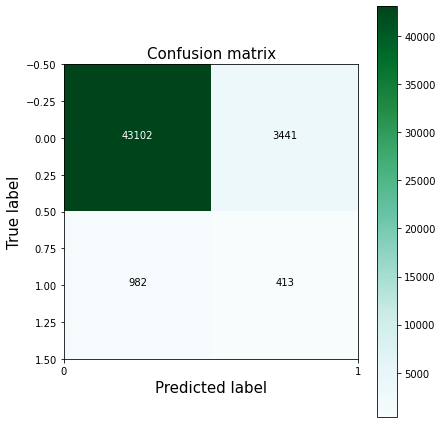

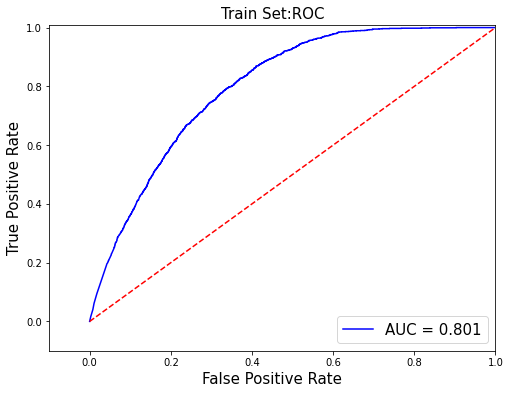

In [15]:
perf_analysis.perf_analysis()

************** Performance: Test Set **************** 

Accuracy: 0.91
Precision: 0.1
Recall: 0.27
F1: 0.14


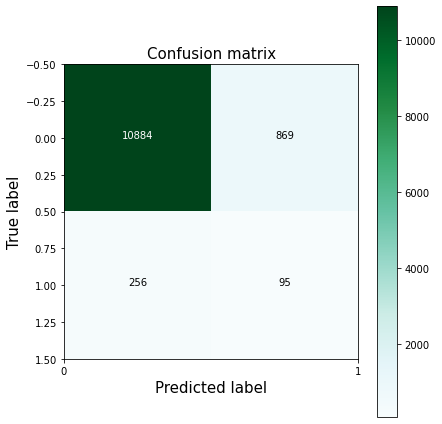

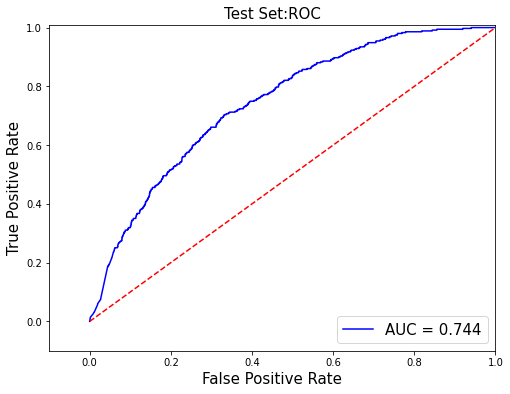

In [17]:
perf_analysis = Modeling_Helper.PerformanceAnalysis(gbm_model, test_df, features, y_var, 'Test Set', cv = True)
perf_analysis.perf_analysis()